In [2]:
import json
import requests as req
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import json


from census import Census
from us import states

# Save config information
api_key = "7824425f0ce43628c75b09e5bfc7c575e283699e"
url = "https://api.census.gov/data/"


In [3]:
# Pull data on businesses and number of establishments

years = ['2010', '2011', '2012', '2013', '2014', '2015']

# Query gets us Number of employees, establishments, size of establishments, year of data collected, annual pay, name of state, for each state
query = "EMP,EMPSZES,EMPSZES_TTL,ESTAB,YEAR,PAYANN,GEO_TTL&for=state:*"

cbp_df = pd.DataFrame()

for year in years: 
    # Build query URL
    query_url = url + year + "/cbp?get=" + query + "&key=" + api_key 

    # This should get us all establishments of employment in each state for the 2015 year.
    cbp_response = req.get(query_url)
    cbp_json = cbp_response.json()
    this_year_cbp = pd.DataFrame(cbp_json, columns =['EMP','EMPSZES','EMPSZES_TTL','ESTAB','YEAR','PAYANN','GEO_TTL','State'])
    
    cbp_df = cbp_df.append(this_year_cbp)

cbp_df.head()

,EMP,EMPSZES,EMPSZES_TTL,ESTAB,YEAR,PAYANN,GEO_TTL,State
0,EMP,EMPSZES,EMPSZES_TTL,ESTAB,YEAR,PAYANN,GEO_TTL,state
1,1568111,001,All establishments,99251,2010,57448016,Alabama,01
2,96042,212,Establishments with 1 to 4 employees,50113,2010,3262347,Alabama,01
3,138569,220,Establishments with 5 to 9 employees,20953,2010,4197349,Alabama,01
4,188244,230,Establishments with 10 to 19 employees,14005,2010,5912838,Alabama,01


In [4]:
clean_cbp = cbp_df.drop([0]).reset_index()
cbp_df = pd.DataFrame(clean_cbp, columns=['GEO_TTL','State','ESTAB','EMP','EMPSZES_TTL','PAYANN','YEAR'])
# download to csv 
cbp_df.to_csv("cbp_df.csv", index=False, header=True)
cbp_df = pd.read_csv("cbp_df.csv",dtype={"ESTAB": int,"EMP":int,"PAYANN":int,"YEAR":str})
cbp_df['key_id'] = cbp_df['GEO_TTL'] + cbp_df['YEAR']
cbp_df.head()

,GEO_TTL,State,ESTAB,EMP,EMPSZES_TTL,PAYANN,YEAR,key_id
0,Alabama,1,99251,1568111,All establishments,57448016,2010,Alabama2010
1,Alabama,1,50113,96042,Establishments with 1 to 4 employees,3262347,2010,Alabama2010
2,Alabama,1,20953,138569,Establishments with 5 to 9 employees,4197349,2010,Alabama2010
3,Alabama,1,14005,188244,Establishments with 10 to 19 employees,5912838,2010,Alabama2010
4,Alabama,1,9021,270606,Establishments with 20 to 49 employees,8808648,2010,Alabama2010


In [5]:
#Let's look at just all Establishments for the past 5 years
est_cbp_df = cbp_df.loc[cbp_df["EMPSZES_TTL"] == "All establishments"]
#Sort by state and year
sort_est_df = est_cbp_df.sort_values(by=['GEO_TTL', 'YEAR'], ascending=[True, True])
sort_est_df.head()

,GEO_TTL,State,ESTAB,EMP,EMPSZES_TTL,PAYANN,YEAR,key_id
0,Alabama,1,99251,1568111,All establishments,57448016,2010,Alabama2010
560,Alabama,1,97743,1573138,All establishments,59241365,2011,Alabama2011
1120,Alabama,1,97938,1585761,All establishments,61284931,2012,Alabama2012
1680,Alabama,1,97578,1603100,All establishments,62408287,2013,Alabama2013
2240,Alabama,1,97714,1604016,All establishments,64291502,2014,Alabama2014


In [53]:
#add minimum wage info
min_wage = "minimum_wage.xlsx"
min_wage_df = pd.read_excel(min_wage, sheetname='Cleaned')
c_min_wage_df = min_wage_df.drop([0,1]).reset_index()


del c_min_wage_df['index']
c_min_wage_df
stk_min_wage = pd.melt(c_min_wage_df, id_vars=['State or other'], var_name='Year')

stk_min_wage['key_id'] = stk_min_wage['State or other'] + stk_min_wage['Year'].map(str)

#merge minimum wage df to all establishment df
mer_min_wage = pd.merge(left=sort_est_df,right=stk_min_wage, left_on='key_id', right_on='key_id')
del mer_min_wage['State or other']
del mer_min_wage['Year']
del mer_min_wage['State']

clean_wage = mer_min_wage.rename(columns={"value": "MIN_WAGE", "GEO_TTL": "STATE"})
clean_wage.head()


,STATE,ESTAB,EMP,EMPSZES_TTL,PAYANN,YEAR,key_id,MIN_WAGE
0,Alabama,99251,1568111,All establishments,57448016,2010,Alabama2010,7.25
1,Alabama,97743,1573138,All establishments,59241365,2011,Alabama2011,7.25
2,Alabama,97938,1585761,All establishments,61284931,2012,Alabama2012,7.25
3,Alabama,97578,1603100,All establishments,62408287,2013,Alabama2013,7.25
4,Alabama,97714,1604016,All establishments,64291502,2014,Alabama2014,7.25


# Income and Poverty per State

In [25]:


# Save config information
api_key = Census("7824425f0ce43628c75b09e5bfc7c575e283699e", year=2015)


census_data = api_key.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E",
                          "B23025_005E"), {'for': 'state:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population", 
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_005E": "Unemployment Count",
                                      "NAME": "Name", "state": "State"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * census_pd["Poverty Count"].astype(int) / census_pd["Population"].astype(int)

# Add in Employment Rate (Employment Count / Population)
census_pd["Unemployment Rate"] = 100 * census_pd["Unemployment Count"].astype(int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["State", "Name", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate", "Unemployment Rate"]]

census_pd.head()

,State,Name,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate
0,02,Alaska,733375.0,33.4,72515.0,33413.0,72957.0,9.948117,4.265894
1,01,Alabama,4830620.0,38.4,43623.0,24091.0,887260.0,18.367415,4.287172
2,05,Arkansas,2958208.0,37.7,41371.0,22798.0,553644.0,18.715520,3.547519
3,04,Arizona,6641928.0,36.8,50255.0,25848.0,1180690.0,17.776314,4.151084
4,06,California,38421464.0,35.8,61818.0,30318.0,6135142.0,15.968007,4.921939


In [21]:
census_pd["Population"].describe().astype(int)

count          52
mean      6155732
std       6992998
min        579679
25%       1792701
50%       4168293
75%       6775555
max      38421464
Name: Population, dtype: int32

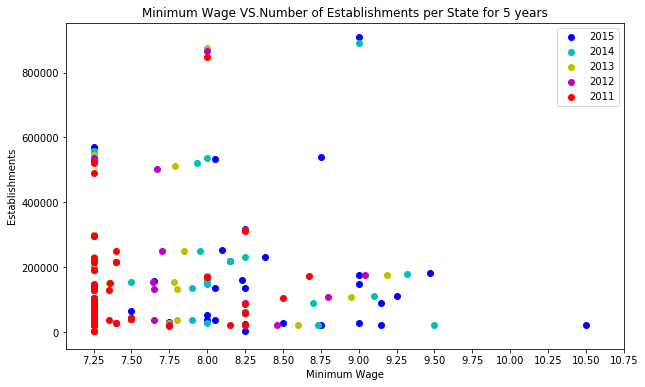

In [48]:
#graph minimum wage vs Establishments 
#Set figure size
plt.figure(figsize = (10,6))
min_wage_plot_2015 = clean_wage.loc[clean_wage["YEAR"] == "2015"]
min_wage_plot_2014 = clean_wage.loc[clean_wage["YEAR"] == "2014"]
min_wage_plot_2013 = clean_wage.loc[clean_wage["YEAR"] == "2013"]
min_wage_plot_2012 = clean_wage.loc[clean_wage["YEAR"] == "2012"]
min_wage_plot_2011 = clean_wage.loc[clean_wage["YEAR"] == "2011"]


#plot with the colors
colors = ['b', 'c', 'y', 'm', 'r']
min_wage_plot_2015 = plt.scatter(min_wage_plot_2015["MIN_WAGE"],min_wage_plot_2015["ESTAB"],c=colors[0])
min_wage_plot_2014 = plt.scatter(min_wage_plot_2014["MIN_WAGE"],min_wage_plot_2014["ESTAB"],c=colors[1])
min_wage_plot_2013 = plt.scatter(min_wage_plot_2013["MIN_WAGE"],min_wage_plot_2013["ESTAB"],c=colors[2])
min_wage_plot_2012 = plt.scatter(min_wage_plot_2012["MIN_WAGE"],min_wage_plot_2012["ESTAB"],c=colors[3])
min_wage_plot_2011 = plt.scatter(min_wage_plot_2011["MIN_WAGE"],min_wage_plot_2011["ESTAB"],c=colors[4])

#Add labels to the x and y axes
plt.title("Minimum Wage VS.Number of Establishments per State for 5 years")
plt.xlabel("Minimum Wage")
plt.ylabel("Establishments")
plt.legend((min_wage_plot_2015, min_wage_plot_2014, min_wage_plot_2013, min_wage_plot_2012,min_wage_plot_2011)
           ,("2015", "2014", "2013","2012","2011"))

plt.xticks(np.arange(7.25,11,.25), size = 10)


# Save Figure
plt.savefig("Min_wage vs. Est.png")

plt.show()


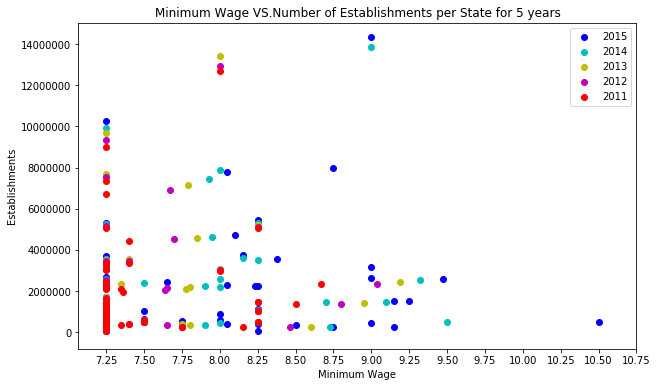

In [51]:

plt.figure(figsize = (10,6))
min_wage_plot_2015 = clean_wage.loc[clean_wage["YEAR"] == "2015"]
min_wage_plot_2014 = clean_wage.loc[clean_wage["YEAR"] == "2014"]
min_wage_plot_2013 = clean_wage.loc[clean_wage["YEAR"] == "2013"]
min_wage_plot_2012 = clean_wage.loc[clean_wage["YEAR"] == "2012"]
min_wage_plot_2011 = clean_wage.loc[clean_wage["YEAR"] == "2011"]


#plot with the colors
colors = ['b', 'c', 'y', 'm', 'r']
min_wage_plot_2015 = plt.scatter(min_wage_plot_2015["MIN_WAGE"],min_wage_plot_2015["EMP"],c=colors[0])
min_wage_plot_2014 = plt.scatter(min_wage_plot_2014["MIN_WAGE"],min_wage_plot_2014["EMP"],c=colors[1])
min_wage_plot_2013 = plt.scatter(min_wage_plot_2013["MIN_WAGE"],min_wage_plot_2013["EMP"],c=colors[2])
min_wage_plot_2012 = plt.scatter(min_wage_plot_2012["MIN_WAGE"],min_wage_plot_2012["EMP"],c=colors[3])
min_wage_plot_2011 = plt.scatter(min_wage_plot_2011["MIN_WAGE"],min_wage_plot_2011["EMP"],c=colors[4])

#Add labels to the x and y axes

plt.title("Minimum Wage VS.Number of Establishments per State for 5 years")
plt.xlabel("Minimum Wage")
plt.ylabel("Establishments")
plt.legend((min_wage_plot_2015, min_wage_plot_2014, min_wage_plot_2013, min_wage_plot_2012,min_wage_plot_2011)
           ,("2015", "2014", "2013","2012","2011"))

plt.xticks(np.arange(7.25,11,.25), size = 10)
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))



# Save Figure
plt.savefig("Emp_vs.Min_wage.png")

plt.show()


In [5]:
#Let's look at just DC for the past 5 years
DC_cbp_df = cbp_df.loc[cbp_df["GEO_TTL"] == "District of Columbia",:]
DC_cbp_df

,GEO_TTL,State,ESTAB,EMP,EMPSZES_TTL,PAYANN,YEAR
80,District of Columbia,11,21502,463076,All establishments,30987176,2010
81,District of Columbia,11,10756,19722,Establishments with 1 to 4 employees,1613293,2010
82,District of Columbia,11,3992,26450,Establishments with 5 to 9 employees,1727571,2010
83,District of Columbia,11,2935,39495,Establishments with 10 to 19 employees,2447540,2010
84,District of Columbia,11,2206,67217,Establishments with 20 to 49 employees,4163103,2010
85,District of Columbia,11,832,57150,Establishments with 50 to 99 employees,3578294,2010
86,District of Columbia,11,538,81006,Establishments with 100 to 249 employees,5901545,2010
87,District of Columbia,11,161,54188,Establishments with 250 to 499 employees,3955738,2010
88,District of Columbia,11,56,39063,Establishments with 500 to 999 employees,2966014,2010
89,District of Columbia,11,26,78785,"Establishments with 1,000 employees or more",4634078,2010
